In [1]:
import hist
import dask
import awkward as ak
import hist.dask as hda
import dask_awkward as dak
import numpy as np



from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector as vec
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
from distributed import Client
client = Client("tls://localhost:8786")

from coffea.lumi_tools import LumiMask
from coffea.nanoevents import NanoAODSchema

GOLDEN_JSON = "Golden_data.json"

class MyProcessor(processor.ProcessorABC):
    def __init__(self, golden_json=None):
        self._mask = LumiMask(golden_json) if golden_json else None

    def process(self, events):
        dataset = events.metadata['dataset']
        is_data = (dataset == "data")

        # --- DATA-only lumi mask bookkeeping ---
        n0 = len(events.event)
        if is_data and (self._mask is not None):
            good = self._mask(events.run, events.luminosityBlock)
            n_keep = ak.count_nonzero(good)
            events = events[good]
        else:
            n_keep = ak.count_nonzero(ak.ones_like(events.event, dtype=bool))
        #print(events.fields)
        #event level cuts
        # apply trigger selection: `HLT_Ele115_CaloIdVT_GsfTrkIdT` OT `HLT_Photon200`
        # Electron.mvaNoIso_WP90 > 0 AND nElectron >= 2
        #event_check = events
        trigger_nelectron = (events.HLT_Ele115_CaloIdVT_GsfTrkIdT | events.HLT_Photon200) & (events.nElectron >= 2)
        events = events[trigger_nelectron]
        electrons = ak.zip(
            {
                "pt": events.Electron_pt,
                "eta": events.Electron_eta,
                "phi": events.Electron_phi,
                "mass": events.Electron_mass,
                "charge": events.Electron_charge,
                "dz": events.Electron_dz,
                "mvaNoIso_WP80": events.Electron_mvaNoIso_WP80,
                "mvaNoIso_WP90": events.Electron_mvaNoIso_WP90,
                "nElectron": events.nElectron,
                "superclusterEta": events.Electron_superclusterEta,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        cut_mva = (electrons.mvaNoIso_WP90 > 0) 
        ele2 = electrons[cut_mva]
        #check---------------------------------------
        ele2_check = ele2
        ###############################################
        #ECAL transition region: 1.44 < |η| < 1.57 that should be vetoed
        abs_sc_eta = np.abs(ele2.superclusterEta)
        eta_trasition_cut = (abs_sc_eta > 1.44) & (abs_sc_eta < 1.57)
        ele2 = ele2[~eta_trasition_cut]
        #check------------------------
        ele2_after_eta_trasition_cut_check = ele2
        ##########################################################
        #tag
        # pt > 120 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
        # barrel ( |eta supercluster| <= 1.479)
        # endcap ( |eta supercluster| > 1.479)
        # Tight MVA ID: Electron.mvaNoIso_WP80 > 0

        is_barrel = (np.abs(ele2.superclusterEta) <= 1.479)
        is_endcap = (np.abs(ele2.superclusterEta) > 1.479) 
        pt_tag_cut  = (ele2.pt > 120)
        abs_superclusterEta_tag_cut= (np.abs(ele2.superclusterEta) < 2.5)
        
        dz_tag_cut  = ak.where(is_barrel, ele2.dz < 0.10, ele2.dz < 0.20)
        tight_mva_cut = (ele2.mvaNoIso_WP80 > 0)
        
        tag_cut = pt_tag_cut & abs_superclusterEta_tag_cut & dz_tag_cut & tight_mva_cut
        e_tag = ele2[tag_cut]
        
        not_tag_e_tagcut = ele2[~tag_cut] # e not passing tagging condition

        #clean up all lists: only events with at least one tag electron remain
        has_tag = ak.num(e_tag) > 0
        e_tag = e_tag[has_tag]
        ele2 = ele2[has_tag]
        not_tag_e_tagcut = not_tag_e_tagcut[has_tag]
        events = events[has_tag] 
        #update list, so that for the new events list, each of them have tag e (at least one)
        #print(events.fields)
        #check-----------------------------------
        e_tag_check = e_tag
        not_tag_e_tagcut_check = not_tag_e_tagcut
        
        ##########################################################
        #match trigger obj
        
        trig_e = ak.zip(
            {
                "pt": events.TrigObj_pt,
                "eta": events.TrigObj_eta,
                "phi": events.TrigObj_phi,
                "mass": ak.zeros_like(events.TrigObj_pt),
                "id": events.TrigObj_id,
                "filterBits": events.TrigObj_filterBits,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        #(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0)
        a = (trig_e.id == 11)
        b = (trig_e.filterBits & (1 << 12)) != 0
        c = (trig_e.filterBits & (1 << 14)) != 0
        trig_obj_cut= a & (b | c)
        trig_electrons = trig_e[trig_obj_cut]
        
        #check if the electron and trigger obj dR matches (if more than 1 tagged e find the one that matches with the trigger obj)
        # Build (electron info), (trigger obj) pairs for every event
        # next want to calculated the delta R between electron and trigger obj
        # when delta R is small, so they match, then this e should be the tag e

        pairs_e_trigObj = ak.cartesian(
            {"e_info": e_tag, "trig_obj": trig_electrons}, axis=1, nested=True
        )
        dR = pairs_e_trigObj.e_info.delta_r(pairs_e_trigObj.trig_obj)
        match_cut = ak.any(dR < 0.1, axis=2)
        e_tag_matched = e_tag[match_cut]
        
        
        not_tag_e_trigObj = e_tag[~match_cut] # e passes tagging condition but not trigObj
        
        keep_evt = ak.num(e_tag_matched) > 0
        events = events[keep_evt]
        e_tag_matched = e_tag_matched[keep_evt] 
        ele2 = ele2[keep_evt]
        e_tag = e_tag[keep_evt]
        not_tag_e_tagcut = not_tag_e_tagcut[keep_evt]
        not_tag_e_trigObj = not_tag_e_trigObj[keep_evt]
        probe_cand = ak.concatenate([not_tag_e_tagcut, not_tag_e_trigObj], axis=1)
        #check----------------------------------
        e_tag_matched_check = e_tag_matched
        probe_cand_check = probe_cand
        
        # update the event/electron list again, now only have events w/ tagged e
        # we have the tagged list and probe_cand list now
        ####################################################
        # now get probe e: pt > 10 GeV AND ak.abs(eta) < 2.5 
        probe_cut = (probe_cand.pt > 10) & (np.abs(probe_cand.superclusterEta) < 2.5)
        probe = probe_cand[probe_cut]
        #check----------------------------------
        probe_check = probe
        ####################################################
        # build the tag-probe pair and test which is within the z mass window
        #!!!!!!!!!!!!!z mass window need to check
        tp_pairs = ak.cartesian({"tag": e_tag_matched, "probe": probe}, axis=1, nested=True)
        p_mu_tot = tp_pairs.tag + tp_pairs.probe
        mass_constructed = p_mu_tot.mass
        z_win = (mass_constructed > 70.0) & (mass_constructed < 110.0)
        good_pairs = tp_pairs[z_win]
        ########################################################
        #the pairs are ready, now we want to see the tag & probe charge
        print("good")
        

        #get different situations of charge
        q_tag   = good_pairs.tag.charge
        q_probe = good_pairs.probe.charge
        
        both_pos = (q_tag > 0) & (q_probe > 0)    
        both_neg = (q_tag < 0) & (q_probe < 0)    
        mixed    = ((q_tag > 0) & (q_probe < 0)) | ((q_tag < 0) & (q_probe > 0))  
        
        n_pp = ak.sum(both_pos)
        n_mm = ak.sum(both_neg)
        n_pm = ak.sum(mixed)
        #n_entries = ak.num(good_pairs.tag, axis=0)
        n_entries=1000000 ###default, will use when needed
        #print("tag and prob")
        #print(n_pp, n_mm, n_pm, n_entries)
        #change the objects to int
        #n_pp, n_mm, n_pm, n_entries = dask.compute(n_pp, n_mm, n_pm, n_entries)
        #print("++:", n_pp)
        #print("--:", n_mm)
        #print("+-:", n_pm)
        #print("all",n_entries)
        ############################## Note: I did not cut the empty elements in the good_pair list, update it if needed 
        
        tag=good_pairs.tag
        probe=good_pairs.probe
        

    
        return {
                #"entries": n_entries,
                "tags": tag,
                "probes": probe,
                "num_pp": n_pp,  
                "num_mm": n_mm,  
                "num_pm": n_pm,
                #"event_check": event_check,
                "ele2_check": ele2_check,
                "e_tag_check": e_tag_check,
                "not_tag_e_tagcut_check": not_tag_e_tagcut_check,
                "e_tag_matched_check": e_tag_matched_check,  
                "probe_cand_check": probe_cand_check,  
                "probe_check": probe_check,
                "ele2_after_eta_trasition_cut_check": ele2_after_eta_trasition_cut_check,
                "n0": n0,             
                "n_keep": n_keep,
    }

    def postprocess(self, accumulator):
        pass

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/usr/local/lib/python3.12/site-packages/distributed/client.py:1613: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| numpy   | 1.26.4 | 1.26.4    | 2.1.3   |
+---------+--------

In [2]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
fileset = {
    'DY_MC': {
        "files": {
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-100to200_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/29f004ec-99e8-41e6-b02e-39b07294ab06.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-200to400_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/aaac973d-7645-471e-85de-72ebf34015f0.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-400to600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2810000/94f7ccff-b6b5-4036-a599-a8e1b2307afb.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-400to600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2810000/a1eb4ac9-17ea-4119-9a67-16c030de773c.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/18197ca8-14a7-4705-acc3-5fbea17f890d.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/185ba806-afd7-4a8b-9235-6e197fd618fc.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/18bc8d9e-aaf7-45db-918f-8a5f93af48c7.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/42992f08-f719-4c8f-8d98-7f9588942ca8.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2520000/8e732505-eeea-45fa-b946-4147fdd1cc35.root': "Events",
            #'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYJetsToLL_M-50_TuneCP5_13p6TeV-madgraphMLM-pythia8/NANOAODSIM/Pilot2024wmLHEGS_150X_mcRun3_2024_realistic_v1-v2/2540000/8908b7ad-b7b7-400c-8c4d-a859666fe8e2.root':"Events",
        }
    },
    'data': {
        "files": {
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/012eaa90-41ee-446b-a0f3-0f13b1e279d4.root': "Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/00035aa1-f176-46ad-8fb9-6ad02849d13e.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/018cd773-9dae-4681-9331-939ae0360e0c.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/04353d0c-ad0d-441d-8db6-a38420dd3a71.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/047ea789-51e9-46a4-843e-7aae58cb51c9.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/06eaf7c4-f21e-45b8-8bd5-c8cb7bf05eae.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/08a87732-2813-4617-b305-d15aa89313dc.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/08b833a5-3764-4da6-8320-e9e5d81ad2ba.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0b93e42b-a62e-4093-bc74-522a97b2b235.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0d27061e-f2c4-4c4d-b9ca-08034bca0490.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0d92b2f1-9031-4591-86ae-45e95138d436.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0ea9d137-856c-48f2-934f-c102c4f79eb5.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/11688c17-2633-4494-862b-76d734b2ea9c.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/127ffb5f-164f-46e1-af64-79e1efeceb7c.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/12f2bee4-7f6a-4a81-8e64-fa2248aa7d4d.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/135b3982-03ea-4877-92dd-56261fa80dd3.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1385920e-f9ad-43e2-8461-620462ff17aa.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/13a2e694-04f4-4ca6-a6fb-19c4db76a86a.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/140d75b1-8ab2-42b8-be8d-0db69df861b4.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1704606a-c3a8-4d93-8124-4e668a8f7ed7.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1824baeb-2871-41ad-9c4b-6823b08fcd6c.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/195fe329-ff08-40e9-bc72-2b70fff0cb3a.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1f446edc-38b5-4f89-a75e-0ca2a5d0763a.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/224fcc72-93ba-4ae9-8358-24426d313fc6.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/24120c75-df67-4036-8918-5f1aad75cf57.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/241251d6-ff75-4962-aafb-2f25d2eb4c6b.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/242f63a7-28df-4ab4-84ce-c05ef3542e59.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/254727db-0ff3-47be-9a29-21804141c93d.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2564db69-592e-4ed4-95bd-8b9f0142b40d.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2646e247-440a-44ba-979b-06678602257f.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2708dd38-6df0-4ac5-ba66-649a49293ee1.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2720c480-25c9-4ec4-b3a2-05ceb7398ebc.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/29529760-5440-4770-b168-52f815eefb58.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2b2e0907-1329-454f-bd79-fb7c2df14ff8.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2ba7577e-f26a-4031-8a40-f5808187206d.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2be738a7-47de-470a-8fb4-8d0323ee9206.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2c02a8f3-0836-4fb9-88b5-e8f60f664982.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2d1f8dd7-db1c-41ed-b37a-cda9103691a3.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2dc6a801-6be2-45ac-b9b1-d63d2d08302b.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3151ab41-a5bd-48f1-be40-449b760a60e6.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/32861731-7f87-4ea0-9fc9-60f4ff08a42f.root':"Events",
            'root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/330d800b-b0ee-4122-a7d7-2bea1672ff25.root':"Events",
            
        }
    }

}


dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

to_compute = apply_to_fileset(
    MyProcessor(golden_json=GOLDEN_JSON),   
    dataset_runnable,
    schemaclass=BaseSchema,              
)
(out,) = dask.compute(to_compute)
ds_mc   = out["DY_MC"]
ds_data = out["data"]  




good
good


In [3]:
n0_mc = ds_mc["n0"]
n_keep_mc = int(ak.to_numpy(ds_mc["n_keep"]).item())
print(f"MC kept {n_keep_mc}/{n0_mc} events")

n0_data = ds_data["n0"]
n_keep_data = int(ak.to_numpy(ds_data["n_keep"]).item())
print(f"data lumimask kept {n_keep_data}/{n0_data} events")

MC kept 4270679/4270679 events
data lumimask kept 37456693/38075094 events


In [ ]:
'''
1st plot:
After event level cut: apply trigger selection: `HLT_Ele115_CaloIdVT_GsfTrkIdT` OT `HLT_Photon200`
Electron.mvaNoIso_WP90 > 0 AND nElectron >= 2
ele2_check 

2nd plot:
After the transition religion cut
ECAL transition region: 1.44 < |η| < 1.57 that should be vetoed
ele2_after_eta_trasition_cut_check

3rd/4th plot:
After general tag selection: # pt > 120 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
        # barrel ( |eta supercluster| <= 1.479)
        # endcap ( |eta supercluster| > 1.479)
        # Tight MVA ID: Electron.mvaNoIso_WP80 > 0
e_tag_check
not_tag_e_tagcut_check

5th/6th plot
After trigger matching 
#(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0) dr<0.1
e_tag_matched_check
probe_cand_check

7th plot
After probe selection:
probe e: pt > 10 GeV AND ak.abs(eta) < 2.5
probe_check
'''


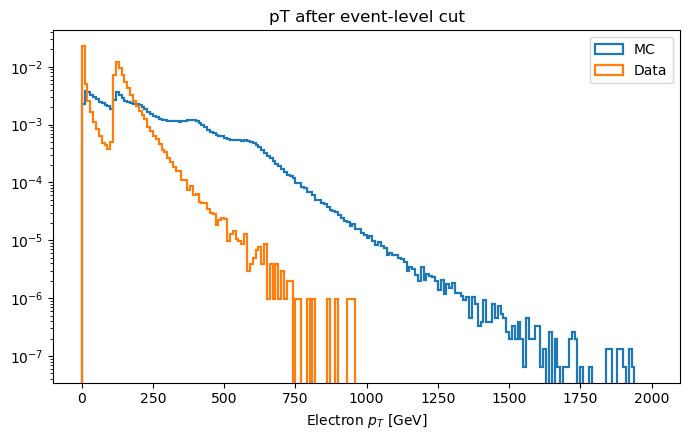

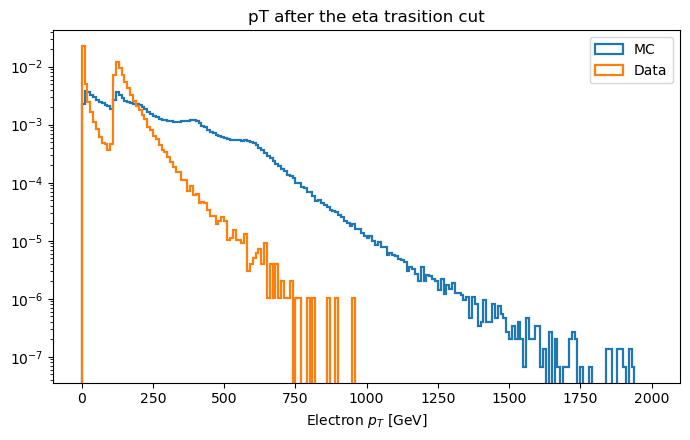

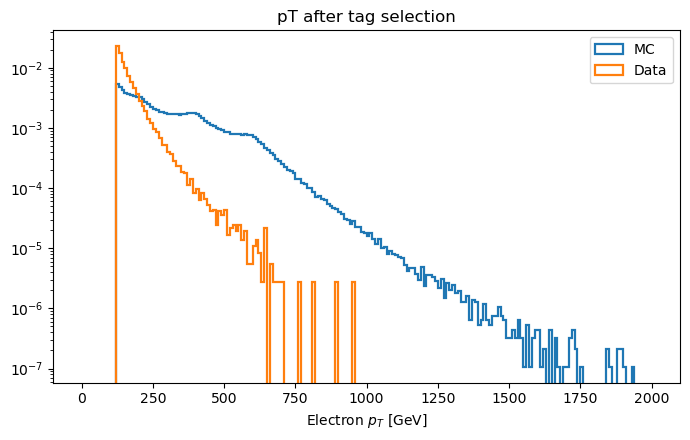

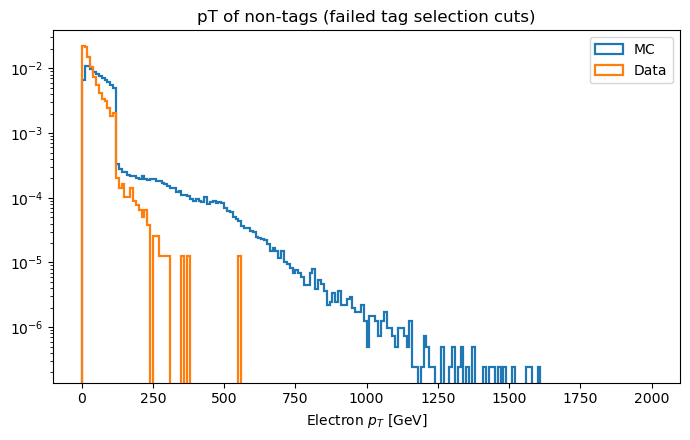

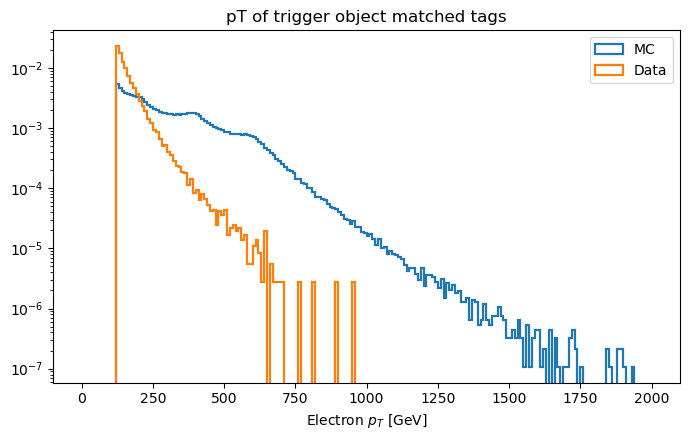

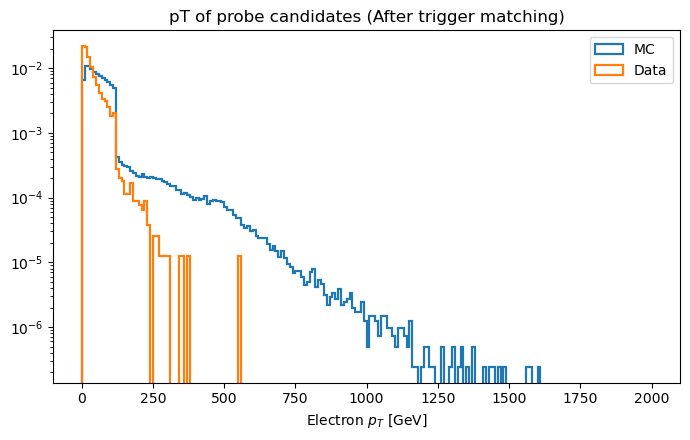

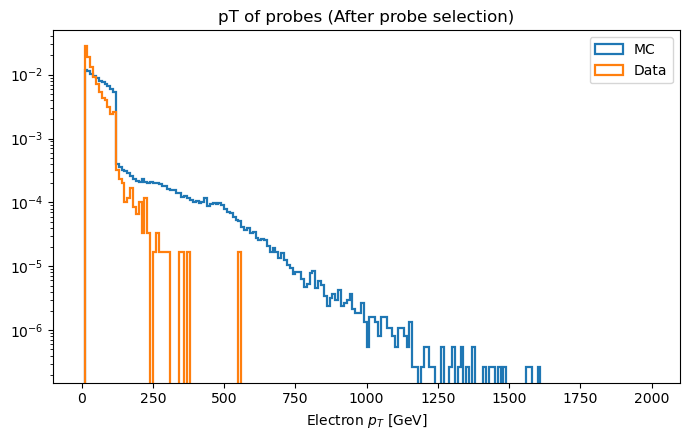

In [4]:
#for MC
#pt_event_check = ak.to_numpy(ak.flatten(ds["event_check"].pt,    axis=None)) # no cut
mc_pt_ele2_check = ak.to_numpy(ak.flatten(ds_mc["ele2_check"].pt,    axis=None))  #After event level cut
mc_pt_ele2_after_eta_trasition_cut_check = ak.to_numpy(ak.flatten(ds_mc["ele2_after_eta_trasition_cut_check"].pt,    axis=None))
mc_pt_e_tag_check = ak.to_numpy(ak.flatten(ds_mc["e_tag_check"].pt,    axis=None))  #After general tag selection
mc_pt_not_tag_e_tagcut_check = ak.to_numpy(ak.flatten(ds_mc["not_tag_e_tagcut_check"].pt,    axis=None))  #After general tag selection
mc_pt_e_tag_matched_check = ak.to_numpy(ak.flatten(ds_mc["e_tag_matched_check"].pt,    axis=None))  #After trigger matching 
mc_pt_probe_cand_check = ak.to_numpy(ak.flatten(ds_mc["probe_cand_check"].pt,    axis=None))  #After trigger matching 
mc_pt_probe_check = ak.to_numpy(ak.flatten(ds_mc["probe_check"].pt,    axis=None))  #After probe selection




# for data
data_pt_ele2_check = ak.to_numpy(ak.flatten(ds_data["ele2_check"].pt,    axis=None))  #After event level cut
data_pt_ele2_after_eta_trasition_cut_check = ak.to_numpy(ak.flatten(ds_data["ele2_after_eta_trasition_cut_check"].pt,    axis=None))
data_pt_e_tag_check = ak.to_numpy(ak.flatten(ds_data["e_tag_check"].pt,    axis=None))  #After general tag selection
data_pt_not_tag_e_tagcut_check = ak.to_numpy(ak.flatten(ds_data["not_tag_e_tagcut_check"].pt,    axis=None))  #After general tag selection
data_pt_e_tag_matched_check = ak.to_numpy(ak.flatten(ds_data["e_tag_matched_check"].pt,    axis=None))  #After trigger matching 
data_pt_probe_cand_check = ak.to_numpy(ak.flatten(ds_data["probe_cand_check"].pt,    axis=None))  #After trigger matching 
data_pt_probe_check = ak.to_numpy(ak.flatten(ds_data["probe_check"].pt,    axis=None))  #After probe selection

import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0, 2000, 201)  

def plot_pt(arr1, arr2, title, bins=bins, logy=True):
    plt.figure(figsize=(7,4.5))
    plt.hist(arr1, bins=bins, density=True, histtype="step", linewidth=1.6, label="MC")
    plt.hist(arr2, bins=bins, density=True, histtype="step", linewidth=1.6, label="Data")
    plt.xlabel("Electron $p_T$ [GeV]")
    #plt.ylabel("# of electrons")
    plt.title(title)
    if logy:
        plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()

#plot_pt(pt_event_check,             "pT for all event")
plot_pt(mc_pt_ele2_check, data_pt_ele2_check, "pT after event-level cut")
plot_pt(mc_pt_ele2_after_eta_trasition_cut_check, data_pt_ele2_after_eta_trasition_cut_check, "pT after the eta trasition cut")
plot_pt(mc_pt_e_tag_check, data_pt_e_tag_check, "pT after tag selection")
plot_pt(mc_pt_not_tag_e_tagcut_check, data_pt_not_tag_e_tagcut_check, "pT of non-tags (failed tag selection cuts)")
plot_pt(mc_pt_e_tag_matched_check, data_pt_e_tag_matched_check, "pT of trigger object matched tags")
plot_pt(mc_pt_probe_cand_check, data_pt_probe_cand_check, "pT of probe candidates (After trigger matching)")
plot_pt(mc_pt_probe_check, data_pt_probe_check, "pT of probes (After probe selection)")







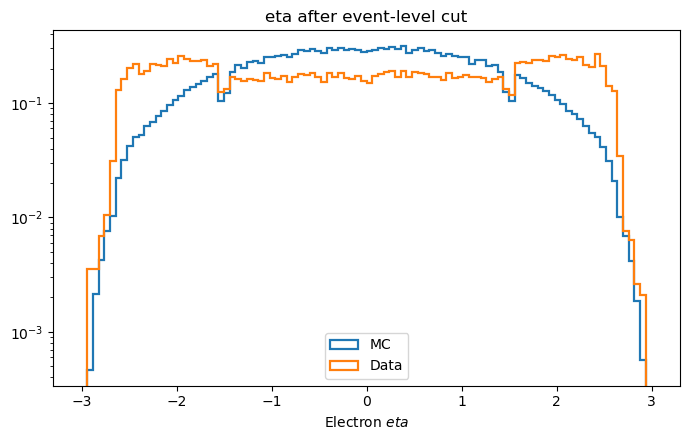

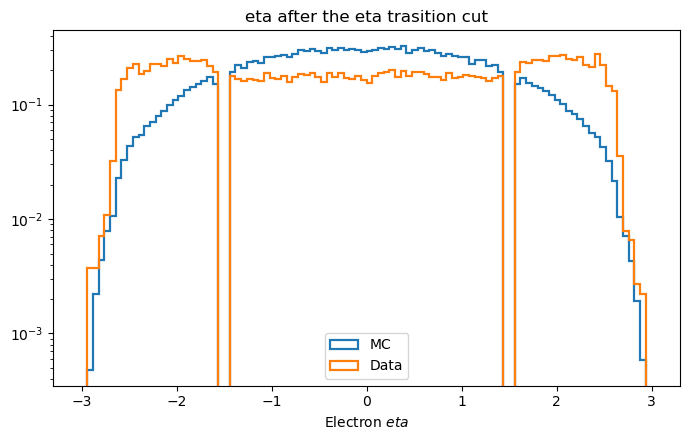

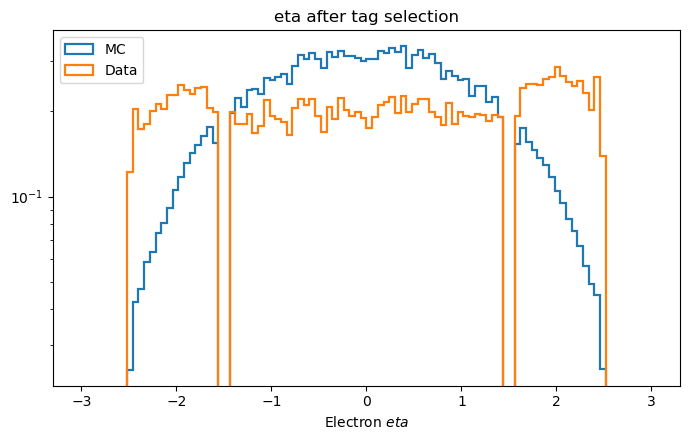

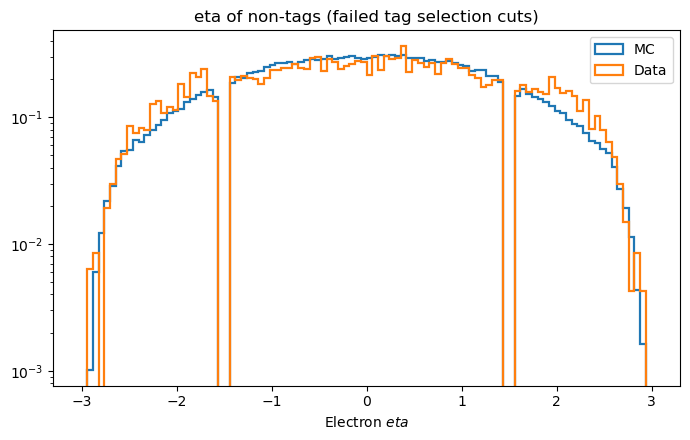

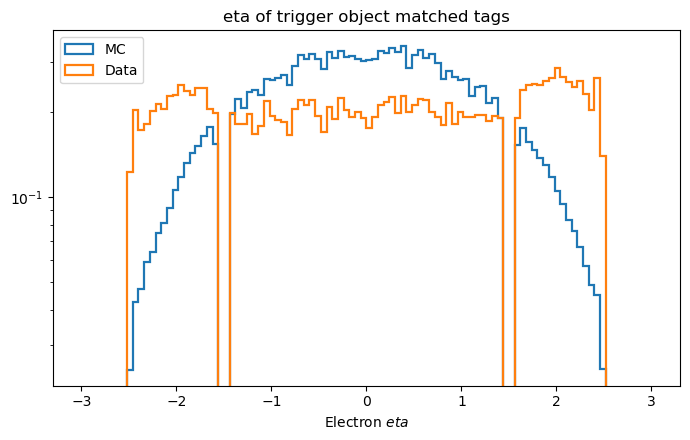

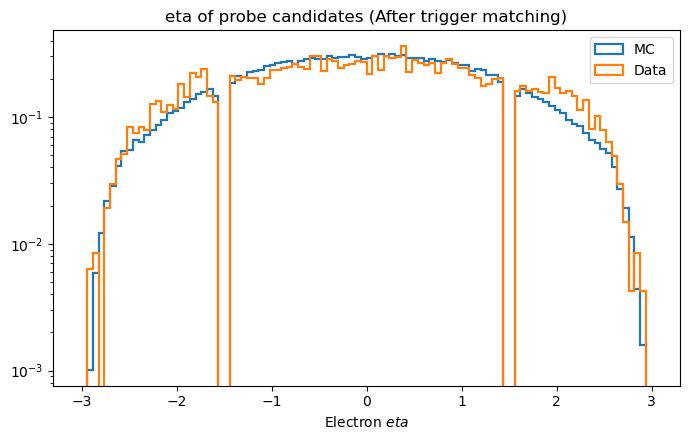

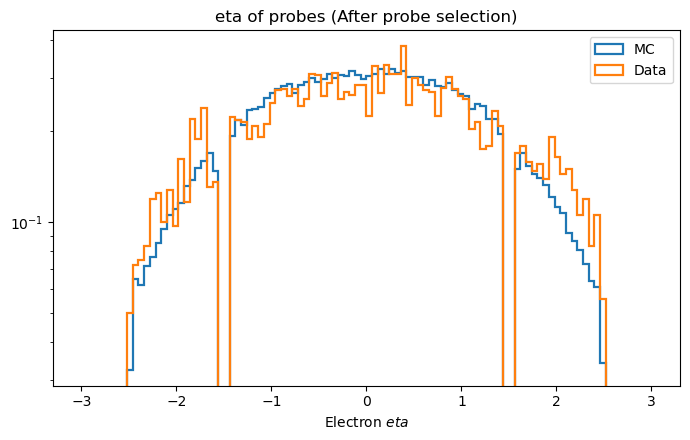

In [5]:
#for mc
#eta_event_check = ak.to_numpy(ak.flatten(ds["event_check"].superclusterEta,    axis=None))
mc_eta_ele2_check = ak.to_numpy(ak.flatten(ds_mc["ele2_check"].superclusterEta,    axis=None))  #After event level cut
mc_eta_ele2_after_eta_trasition_cut_check = ak.to_numpy(ak.flatten(ds_mc["ele2_after_eta_trasition_cut_check"].superclusterEta,    axis=None))
mc_eta_e_tag_check = ak.to_numpy(ak.flatten(ds_mc["e_tag_check"].superclusterEta,    axis=None))  #After general tag selection
mc_eta_not_tag_e_tagcut_check = ak.to_numpy(ak.flatten(ds_mc["not_tag_e_tagcut_check"].superclusterEta,    axis=None))  #After general tag selection
mc_eta_e_tag_matched_check = ak.to_numpy(ak.flatten(ds_mc["e_tag_matched_check"].superclusterEta,    axis=None))  #After trigger matching 
mc_eta_probe_cand_check = ak.to_numpy(ak.flatten(ds_mc["probe_cand_check"].superclusterEta,    axis=None))  #After trigger matching 
mc_eta_probe_check = ak.to_numpy(ak.flatten(ds_mc["probe_check"].superclusterEta,    axis=None))  #After probe selection

#for data
data_eta_ele2_check = ak.to_numpy(ak.flatten(ds_data["ele2_check"].superclusterEta,    axis=None))  #After event level cut
data_eta_ele2_after_eta_trasition_cut_check = ak.to_numpy(ak.flatten(ds_data["ele2_after_eta_trasition_cut_check"].superclusterEta,    axis=None))
data_eta_e_tag_check = ak.to_numpy(ak.flatten(ds_data["e_tag_check"].superclusterEta,    axis=None))  #After general tag selection
data_eta_not_tag_e_tagcut_check = ak.to_numpy(ak.flatten(ds_data["not_tag_e_tagcut_check"].superclusterEta,    axis=None))  #After general tag selection
data_eta_e_tag_matched_check = ak.to_numpy(ak.flatten(ds_data["e_tag_matched_check"].superclusterEta,    axis=None))  #After trigger matching 
data_eta_probe_cand_check = ak.to_numpy(ak.flatten(ds_data["probe_cand_check"].superclusterEta,    axis=None))  #After trigger matching 
data_eta_probe_check = ak.to_numpy(ak.flatten(ds_data["probe_check"].superclusterEta,    axis=None))  #After probe selection

import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(-3, 3, 101)  

def plot_pt(arr1, arr2, title, bins=bins, logy=True):
    plt.figure(figsize=(7,4.5))
    plt.hist(arr1, bins=bins, density=True, histtype="step", linewidth=1.6, label="MC")
    plt.hist(arr2, bins=bins, density=True, histtype="step", linewidth=1.6, label="Data")
    plt.xlabel("Electron $eta$")
    #plt.ylabel("# of electrons")
    plt.title(title)
    if logy:
        plt.yscale("log")
    plt.tight_layout()
    plt.legend()
    plt.show()

#plot_pt(eta_event_check,             "eta for all event")
plot_pt(mc_eta_ele2_check, data_eta_ele2_check, "eta after event-level cut")
plot_pt(mc_eta_ele2_after_eta_trasition_cut_check, data_eta_ele2_after_eta_trasition_cut_check, "eta after the eta trasition cut")
plot_pt(mc_eta_e_tag_check, data_eta_e_tag_check, "eta after tag selection")
plot_pt(mc_eta_not_tag_e_tagcut_check, data_eta_not_tag_e_tagcut_check, "eta of non-tags (failed tag selection cuts)")
plot_pt(mc_eta_e_tag_matched_check, data_eta_e_tag_matched_check, "eta of trigger object matched tags")
plot_pt(mc_eta_probe_cand_check, data_eta_probe_cand_check, "eta of probe candidates (After trigger matching)")
plot_pt(mc_eta_probe_check, data_eta_probe_check, "eta of probes (After probe selection)")






In [6]:
#Flatten the arrays first (original:[event][tag][what we want]; now:[.,.,.,.])

#for MC
mc_q_tag    = ak.to_numpy(ak.flatten(ds_mc["tags"].charge,   axis=None))
mc_q_probe  = ak.to_numpy(ak.flatten(ds_mc["probes"].charge, axis=None))
mc_pt_probe = ak.to_numpy(ak.flatten(ds_mc["probes"].pt,    axis=None))
mc_eta_probe = ak.to_numpy(ak.flatten(ds_mc["probes"].superclusterEta,    axis=None))

# Masks
mc_m_pp = (mc_q_tag > 0) & (mc_q_probe > 0)
mc_m_mm = (mc_q_tag < 0) & (mc_q_probe < 0)
mc_m_pm = (mc_q_tag * mc_q_probe) < 0

# Totals
mc_n_pp = int(np.sum(mc_m_pp))
mc_n_mm = int(np.sum(mc_m_mm))
mc_n_pm = int(np.sum(mc_m_pm))

print("for MC")
print("++ rows:", mc_n_pp)
print("-- rows:", mc_n_mm)
print("+- rows:", mc_n_pm)



#for data
data_q_tag    = ak.to_numpy(ak.flatten(ds_data["tags"].charge,   axis=None))
data_q_probe  = ak.to_numpy(ak.flatten(ds_data["probes"].charge, axis=None))
data_pt_probe = ak.to_numpy(ak.flatten(ds_data["probes"].pt,    axis=None))
data_eta_probe = ak.to_numpy(ak.flatten(ds_data["probes"].superclusterEta,    axis=None))

# Masks
data_m_pp = (data_q_tag > 0) & (data_q_probe > 0)
data_m_mm = (data_q_tag < 0) & (data_q_probe < 0)
data_m_pm = (data_q_tag * data_q_probe) < 0

# Totals
data_n_pp = int(np.sum(data_m_pp))
data_n_mm = int(np.sum(data_m_mm))
data_n_pm = int(np.sum(data_m_pm))

print("for data")
print("++ rows:", data_n_pp)
print("-- rows:", data_n_mm)
print("+- rows:", data_n_pm)

for MC
++ rows: 3066
-- rows: 2838
+- rows: 326003
for data
++ rows: 57
-- rows: 52
+- rows: 4193


/tmp/ipykernel_207/3029375543.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


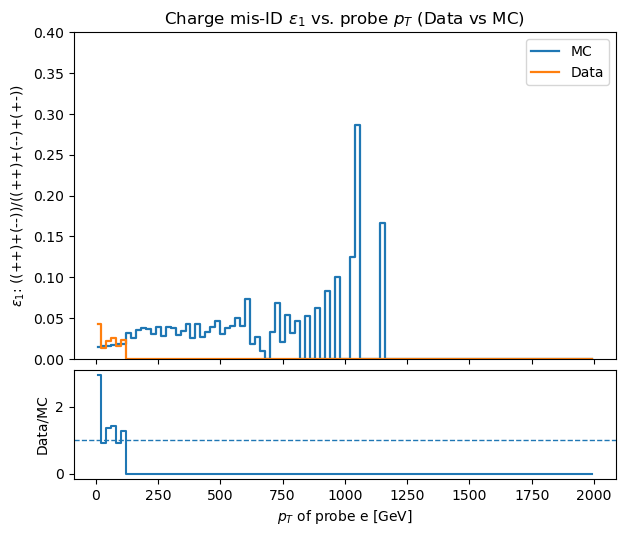

In [8]:
#factor vs. pT
bins_pt = np.linspace(0, 2000, 101)
centers_pt = 0.5 * (bins_pt[1:] + bins_pt[:-1])

#for mc
mc_cut_pp = (mc_q_tag > 0) & (mc_q_probe > 0)
mc_cut_mm = (mc_q_tag < 0) & (mc_q_probe < 0)
mc_cut_pm = ((mc_q_tag > 0) & (mc_q_probe < 0)) | ((mc_q_tag < 0) & (mc_q_probe > 0)) 

mc_pp_pt, _ = np.histogram(mc_pt_probe[mc_cut_pp], bins=bins_pt)
mc_mm_pt, _ = np.histogram(mc_pt_probe[mc_cut_mm], bins=bins_pt)
mc_pm_pt, _ = np.histogram(mc_pt_probe[mc_cut_pm], bins=bins_pt)

mc_same_pt = mc_pp_pt + mc_mm_pt
mc_tot_pt  = mc_same_pt + mc_pm_pt
mc_ratio_pt = np.divide(mc_same_pt, mc_tot_pt, out=np.zeros_like(mc_same_pt, dtype=float), where=mc_tot_pt > 0)


#for data
data_cut_pp = (data_q_tag > 0) & (data_q_probe > 0)
data_cut_mm = (data_q_tag < 0) & (data_q_probe < 0)
data_cut_pm = ((data_q_tag > 0) & (data_q_probe < 0)) | ((data_q_tag < 0) & (data_q_probe > 0)) 

data_pp_pt, _ = np.histogram(data_pt_probe[data_cut_pp], bins=bins_pt)
data_mm_pt, _ = np.histogram(data_pt_probe[data_cut_mm], bins=bins_pt)
data_pm_pt, _ = np.histogram(data_pt_probe[data_cut_pm], bins=bins_pt)

data_same_pt = data_pp_pt + data_mm_pt
data_tot_pt  = data_same_pt + data_pm_pt
data_ratio_pt = np.divide(data_same_pt, data_tot_pt, out=np.zeros_like(data_same_pt, dtype=float), where=data_tot_pt > 0)




ratio_pt = np.divide(data_ratio_pt, mc_ratio_pt, out=np.zeros_like(data_ratio_pt, dtype=float), where=mc_ratio_pt>0)

fig = plt.figure(figsize=(7, 5.8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax  = fig.add_subplot(gs[0])
rax = fig.add_subplot(gs[1], sharex=ax)

ax.step(centers_pt, mc_ratio_pt,   where="mid", linewidth=1.6, label="MC")
ax.step(centers_pt, data_ratio_pt, where="mid", linewidth=1.6, label="Data")
ax.set_ylim(0, 0.4)
ax.set_ylabel(r"$\epsilon_1$: ((++)+(--))/((++)+(--)+(+-))")
ax.set_title(r"Charge mis-ID $\epsilon_1$ vs. probe $p_T$ (Data vs MC)")
ax.legend()

rax.axhline(1.0, linestyle="--", linewidth=1)
rax.step(centers_pt, ratio_pt, where="mid")
rax.set_ylabel("Data/MC")
rax.set_xlabel(r"$p_T$ of probe e [GeV]")
#rax.set_ylim(0, 1.1)

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()


/tmp/ipykernel_207/719563304.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


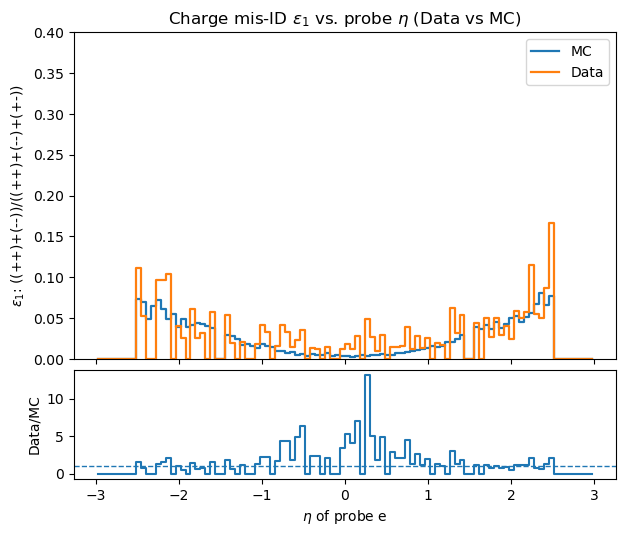

In [10]:
# factor vs. eta
bins_eta = np.linspace(-3, 3, 101)
centers_eta = 0.5 * (bins_eta[1:] + bins_eta[:-1])

#for mc
mc_pp_eta, _ = np.histogram(mc_eta_probe[mc_cut_pp], bins=bins_eta)
mc_mm_eta, _ = np.histogram(mc_eta_probe[mc_cut_mm], bins=bins_eta)
mc_pm_eta, _ = np.histogram(mc_eta_probe[mc_cut_pm], bins=bins_eta)

mc_same_eta = mc_pp_eta + mc_mm_eta
mc_tot_eta  = mc_same_eta + mc_pm_eta
mc_ratio_eta = np.divide(mc_same_eta, mc_tot_eta, out=np.zeros_like(mc_same_eta, dtype=float), where=mc_tot_eta > 0)

#for data
data_pp_eta, _ = np.histogram(data_eta_probe[data_cut_pp], bins=bins_eta)
data_mm_eta, _ = np.histogram(data_eta_probe[data_cut_mm], bins=bins_eta)
data_pm_eta, _ = np.histogram(data_eta_probe[data_cut_pm], bins=bins_eta)

data_same_eta = data_pp_eta + data_mm_eta
data_tot_eta  = data_same_eta + data_pm_eta
data_ratio_eta = np.divide(data_same_eta, data_tot_eta, out=np.zeros_like(data_same_eta, dtype=float), where=data_tot_eta > 0)

ratio_eta = np.divide(data_ratio_eta, mc_ratio_eta, out=np.zeros_like(data_ratio_eta, dtype=float), where=mc_ratio_eta>0)

fig = plt.figure(figsize=(7, 5.8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax  = fig.add_subplot(gs[0])
rax = fig.add_subplot(gs[1], sharex=ax)

ax.step(centers_eta, mc_ratio_eta,   where="mid", linewidth=1.6, label="MC")
ax.step(centers_eta, data_ratio_eta, where="mid", linewidth=1.6, label="Data")
ax.set_ylim(0, 0.4)
ax.set_ylabel(r"$\epsilon_1$: ((++)+(--))/((++)+(--)+(+-))")
ax.set_title(r"Charge mis-ID $\epsilon_1$ vs. probe $\eta$ (Data vs MC)")
ax.legend()

rax.axhline(1.0, linestyle="--", linewidth=1)
rax.step(centers_eta, ratio_eta, where="mid")
rax.set_ylabel("Data/MC")
rax.set_xlabel(r"$\eta$ of probe e")
#rax.set_ylim(0, 1.1)

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()


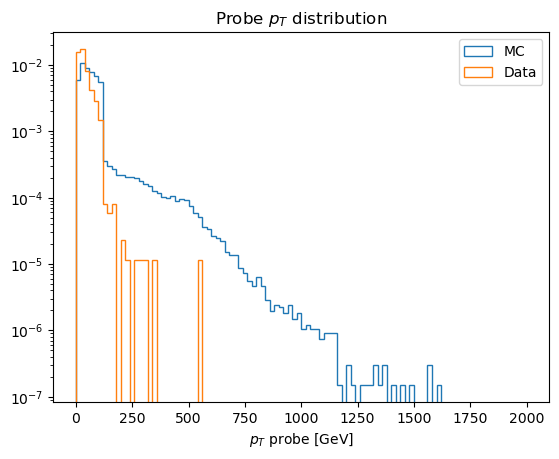

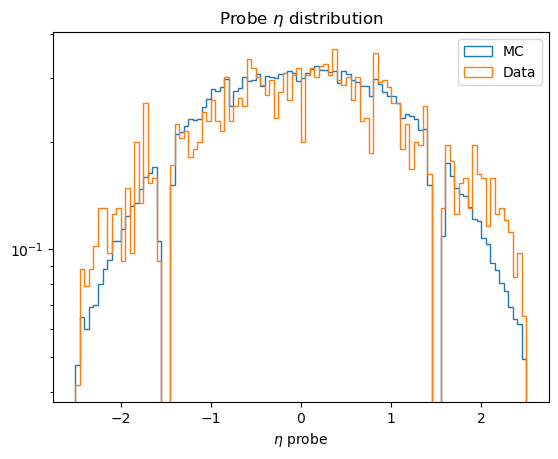

In [11]:
# check pT and eta distribution of the probe e
import numpy as np
import matplotlib.pyplot as plt

bins_pt_check = np.linspace(0, 2000, 101)  

plt.figure()
plt.hist(mc_pt_probe, bins=bins_pt_check, density=True, histtype="step", label="MC")
plt.hist(data_pt_probe, bins=bins_pt_check, density=True, histtype="step", label="Data")
plt.xlabel(r"$p_T$ probe [GeV]")
#plt.ylabel("# of events")
plt.yscale("log")
plt.title("Probe $p_T$ distribution")
plt.legend()
plt.show()


bins_eta_check = np.linspace(-2.5, 2.5, 101)
plt.figure()
plt.hist(mc_eta_probe, bins=bins_eta_check, density=True, histtype="step", label="MC")
plt.hist(data_eta_probe, bins=bins_eta_check, density=True, histtype="step", label="Data")
plt.xlabel(r"$\eta$ probe")
#plt.ylabel("# of events")
plt.yscale("log")
plt.title(r"Probe $\eta$ distribution")
plt.legend()
plt.show()


In [ ]:
# calculate epsilon_2: (++)/((++)+(--))

/tmp/ipykernel_207/1868491166.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


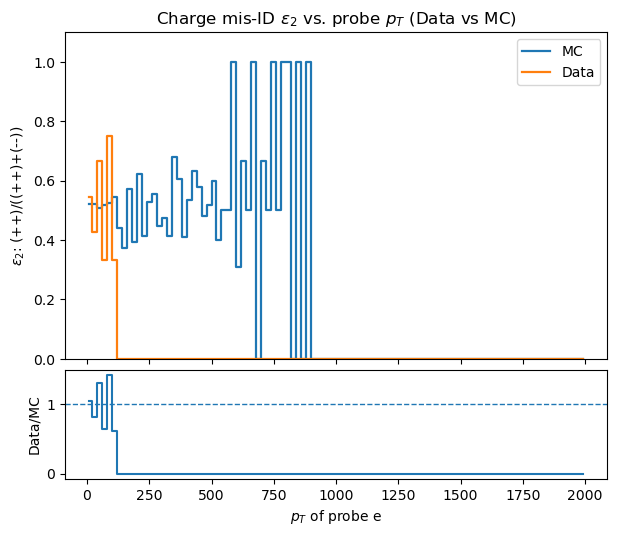

In [12]:
#epsilon_2 vs. pT
bins_pt = np.linspace(0, 2000, 101)
centers_pt = 0.5 * (bins_pt[1:] + bins_pt[:-1])

mc_epsilon2_pt = np.divide(mc_pp_pt, mc_same_pt, out=np.zeros_like(mc_pp_pt, dtype=float), where=mc_same_pt > 0)

data_epsilon2_pt = np.divide(data_pp_pt, data_same_pt, out=np.zeros_like(data_pp_pt, dtype=float), where=data_same_pt > 0)

ratio_epsilon2_pt = np.divide(data_epsilon2_pt, mc_epsilon2_pt, out=np.zeros_like(data_epsilon2_pt, dtype=float), where=mc_epsilon2_pt>0)

fig = plt.figure(figsize=(7, 5.8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax  = fig.add_subplot(gs[0])
rax = fig.add_subplot(gs[1], sharex=ax)

ax.step(centers_pt, mc_epsilon2_pt,   where="mid", linewidth=1.6, label="MC")
ax.step(centers_pt, data_epsilon2_pt, where="mid", linewidth=1.6, label="Data")
ax.set_ylim(0, 1.1)
ax.set_ylabel(r"$\epsilon_2$: (++)/((++)+(--))")
ax.set_title(r"Charge mis-ID $\epsilon_2$ vs. probe $p_T$ (Data vs MC)")
ax.legend()

rax.axhline(1.0, linestyle="--", linewidth=1)
rax.step(centers_pt, ratio_epsilon2_pt, where="mid")
rax.set_ylabel("Data/MC")
rax.set_xlabel(r"$p_T$ of probe e")
#rax.set_ylim(0, 1.1)

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()





/tmp/ipykernel_207/2330466739.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


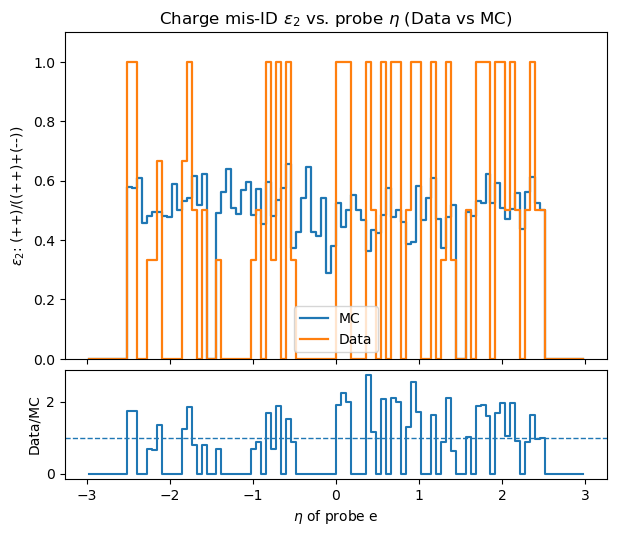

In [13]:
#epsilon_2 vs. eta
bins_eta = np.linspace(-3, 3, 101)
centers_eta = 0.5 * (bins_eta[1:] + bins_eta[:-1])

mc_epsilon2_eta = np.divide(mc_pp_eta, mc_same_eta, out=np.zeros_like(mc_pp_eta, dtype=float), where=mc_same_eta > 0)
data_epsilon2_eta = np.divide(data_pp_eta, data_same_eta, out=np.zeros_like(data_pp_eta, dtype=float), where=data_same_eta > 0)

ratio_epsilon2_eta = np.divide(data_epsilon2_eta, mc_epsilon2_eta, out=np.zeros_like(data_epsilon2_eta, dtype=float), where=mc_epsilon2_eta>0)

fig = plt.figure(figsize=(7, 5.8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax  = fig.add_subplot(gs[0])
rax = fig.add_subplot(gs[1], sharex=ax)

ax.step(centers_eta, mc_epsilon2_eta,   where="mid", linewidth=1.6, label="MC")
ax.step(centers_eta, data_epsilon2_eta, where="mid", linewidth=1.6, label="Data")
ax.set_ylim(0, 1.1)
ax.set_ylabel(r"$\epsilon_2$: (++)/((++)+(--))")
ax.set_title(r"Charge mis-ID $\epsilon_2$ vs. probe $\eta$ (Data vs MC)")
ax.legend()

rax.axhline(1.0, linestyle="--", linewidth=1)
rax.step(centers_eta, ratio_epsilon2_eta, where="mid")
rax.set_ylabel("Data/MC")
rax.set_xlabel(r"$\eta$ of probe e")
#rax.set_ylim(0, 1.1)

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()



In [ ]:
# z mass window i choose 70-110
# MC root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J
# each mass point should have roughly around 800000 events

#check invariant mass of the 2e make sure the distribution shape
#all eta cuts are using supercluster eta ###check!
#points with error bar plot for both eta and pT distribution

In [ ]:
# seperate barrel and endcap

/tmp/ipykernel_207/996110515.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


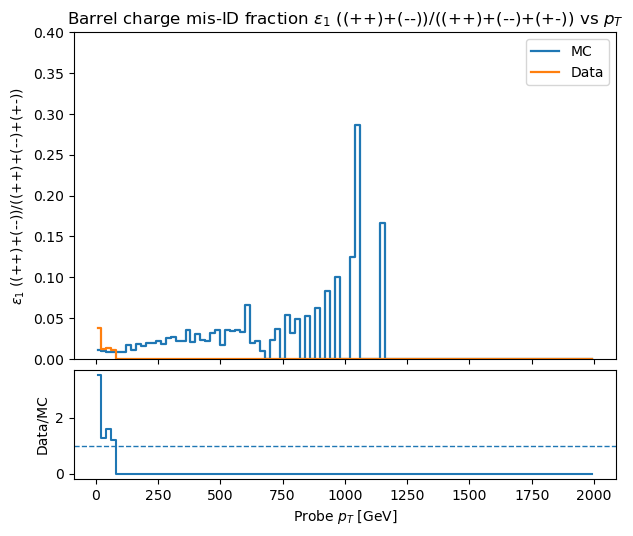

/tmp/ipykernel_207/996110515.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


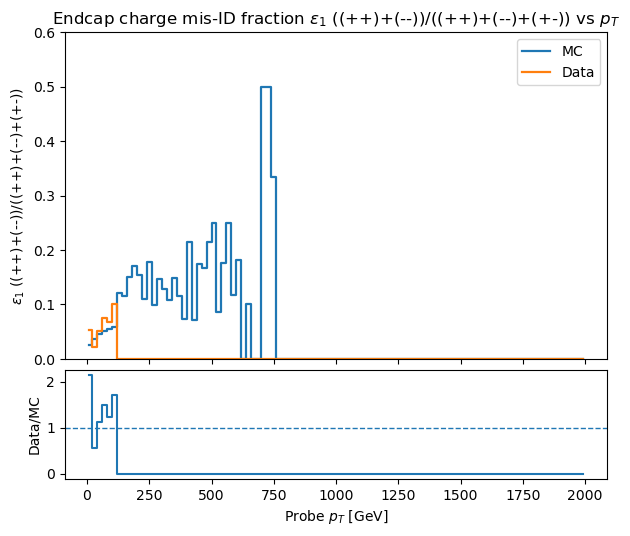

In [17]:
# for epsilon_1 ((++)+(--))/((++)+(--)+(+-))

mc_barrel = (np.abs(mc_eta_probe) <= 1.479)
mc_endcap = (np.abs(mc_eta_probe) > 1.479)

data_barrel = (np.abs(data_eta_probe) <= 1.479)
data_endcap = (np.abs(data_eta_probe) > 1.479)

bins_pt = np.linspace(0, 2000, 101)
centers_pt = 0.5 * (bins_pt[1:] + bins_pt[:-1])



# Barrel
mc_ss_barrel_mask   = (mc_m_pp | mc_m_mm) & mc_barrel
mc_tot_barrel_mask  = (mc_m_pp | mc_m_mm | mc_m_pm) & mc_barrel
mc_same_barrel_pt, _ = np.histogram(mc_pt_probe[mc_ss_barrel_mask],  bins=bins_pt)
mc_tot_barrel_pt,  _ = np.histogram(mc_pt_probe[mc_tot_barrel_mask], bins=bins_pt)
mc_epsilon1_barrel_pt   = np.divide(mc_same_barrel_pt, mc_tot_barrel_pt,
                              out=np.zeros_like(mc_same_barrel_pt, dtype=float),
                              where=mc_tot_barrel_pt > 0)

data_ss_barrel_mask   = (data_m_pp | data_m_mm) & data_barrel
data_tot_barrel_mask  = (data_m_pp | data_m_mm | data_m_pm) & data_barrel
data_same_barrel_pt, _ = np.histogram(data_pt_probe[data_ss_barrel_mask],  bins=bins_pt)
data_tot_barrel_pt,  _ = np.histogram(data_pt_probe[data_tot_barrel_mask], bins=bins_pt)
data_epsilon1_barrel_pt   = np.divide(data_same_barrel_pt, data_tot_barrel_pt,
                              out=np.zeros_like(data_same_barrel_pt, dtype=float),
                              where=data_tot_barrel_pt > 0)

# Endcap
mc_ss_endcap_mask   = (mc_m_pp | mc_m_mm) & mc_endcap
mc_tot_endcap_mask  = (mc_m_pp | mc_m_mm | mc_m_pm) & mc_endcap
mc_same_endcap_pt, _ = np.histogram(mc_pt_probe[mc_ss_endcap_mask],  bins=bins_pt)
mc_tot_endcap_pt,  _ = np.histogram(mc_pt_probe[mc_tot_endcap_mask], bins=bins_pt)
mc_epsilon1_endcap_pt   = np.divide(mc_same_endcap_pt, mc_tot_endcap_pt,
                              out=np.zeros_like(mc_same_endcap_pt, dtype=float),
                              where=mc_tot_endcap_pt > 0)

data_ss_endcap_mask   = (data_m_pp | data_m_mm) & data_endcap
data_tot_endcap_mask  = (data_m_pp | data_m_mm | data_m_pm) & data_endcap
data_same_endcap_pt, _ = np.histogram(data_pt_probe[data_ss_endcap_mask],  bins=bins_pt)
data_tot_endcap_pt,  _ = np.histogram(data_pt_probe[data_tot_endcap_mask], bins=bins_pt)
data_epsilon1_endcap_pt   = np.divide(data_same_endcap_pt, data_tot_endcap_pt,
                              out=np.zeros_like(data_same_endcap_pt, dtype=float),
                              where=data_tot_endcap_pt > 0)


ratio_epsilon1_barrel_pt = np.divide(data_epsilon1_barrel_pt, mc_epsilon1_barrel_pt, out=np.zeros_like(data_epsilon1_barrel_pt, dtype=float), where=mc_epsilon1_barrel_pt>0)
ratio_epsilon1_endcap_pt = np.divide(data_epsilon1_endcap_pt, mc_epsilon1_endcap_pt, out=np.zeros_like(data_epsilon1_endcap_pt, dtype=float), where=mc_epsilon1_endcap_pt>0)

fig = plt.figure(figsize=(7, 5.8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax  = fig.add_subplot(gs[0])
rax = fig.add_subplot(gs[1], sharex=ax)

ax.step(centers_pt, mc_epsilon1_barrel_pt,   where="mid", linewidth=1.6, label="MC")
ax.step(centers_pt, data_epsilon1_barrel_pt, where="mid", linewidth=1.6, label="Data")
ax.set_ylim(0, 0.4)
ax.set_ylabel(r"$\epsilon_1$ ((++)+(--))/((++)+(--)+(+-))")
ax.set_title(r"Barrel charge mis-ID fraction $\epsilon_1$ ((++)+(--))/((++)+(--)+(+-)) vs $p_T$")
ax.legend()

rax.axhline(1.0, linestyle="--", linewidth=1)
rax.step(centers_pt, ratio_epsilon1_barrel_pt, where="mid")
rax.set_ylabel("Data/MC")
rax.set_xlabel(r"Probe $p_T$ [GeV]")
#rax.set_ylim(0, 1.1)

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()



fig = plt.figure(figsize=(7, 5.8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax  = fig.add_subplot(gs[0])
rax = fig.add_subplot(gs[1], sharex=ax)

ax.step(centers_pt, mc_epsilon1_endcap_pt,   where="mid", linewidth=1.6, label="MC")
ax.step(centers_pt, data_epsilon1_endcap_pt, where="mid", linewidth=1.6, label="Data")
ax.set_ylim(0, 0.6)
ax.set_ylabel(r"$\epsilon_1$ ((++)+(--))/((++)+(--)+(+-))")
ax.set_title(r"Endcap charge mis-ID fraction $\epsilon_1$ ((++)+(--))/((++)+(--)+(+-)) vs $p_T$")
ax.legend()

rax.axhline(1.0, linestyle="--", linewidth=1)
rax.step(centers_pt, ratio_epsilon1_endcap_pt, where="mid")
rax.set_ylabel("Data/MC")
rax.set_xlabel(r"Probe $p_T$ [GeV]")
#rax.set_ylim(0, 1.1)

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()










/tmp/ipykernel_207/1586140173.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


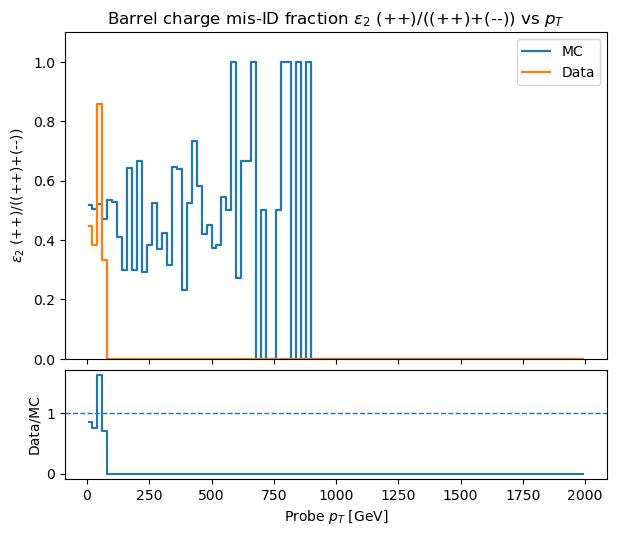

/tmp/ipykernel_207/1586140173.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


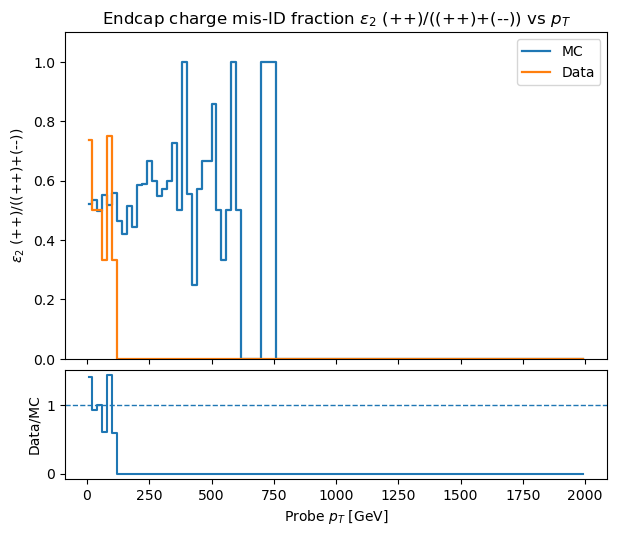

In [18]:
# for epsilon_2 (++)/((++)+(--))

bins_pt = np.linspace(0, 2000, 101)
centers_pt = 0.5 * (bins_pt[1:] + bins_pt[:-1])



# Barrel
mc_pp_barrel_mask   = mc_m_pp & mc_barrel

mc_pp_barrel_pt, _ = np.histogram(mc_pt_probe[mc_pp_barrel_mask],  bins=bins_pt)
mc_epsilon2_barrel_pt   = np.divide(mc_pp_barrel_pt, mc_same_barrel_pt,
                              out=np.zeros_like(mc_pp_barrel_pt, dtype=float),
                              where=mc_same_barrel_pt > 0)

data_pp_barrel_mask   = data_m_pp & data_barrel

data_pp_barrel_pt, _ = np.histogram(data_pt_probe[data_pp_barrel_mask],  bins=bins_pt)
data_epsilon2_barrel_pt   = np.divide(data_pp_barrel_pt, data_same_barrel_pt,
                              out=np.zeros_like(data_pp_barrel_pt, dtype=float),
                              where=data_same_barrel_pt > 0)

# Endcap
mc_pp_endcap_mask   = mc_m_pp & mc_endcap
mc_pp_endcap_pt, _ = np.histogram(mc_pt_probe[mc_pp_endcap_mask],  bins=bins_pt)

mc_epsilon2_endcap_pt   = np.divide(mc_pp_endcap_pt, mc_same_endcap_pt,
                              out=np.zeros_like(mc_pp_endcap_pt, dtype=float),
                              where=mc_same_endcap_pt > 0)

data_pp_endcap_mask   = data_m_pp & data_endcap
data_pp_endcap_pt, _ = np.histogram(data_pt_probe[data_pp_endcap_mask],  bins=bins_pt)

data_epsilon2_endcap_pt   = np.divide(data_pp_endcap_pt, data_same_endcap_pt,
                              out=np.zeros_like(data_pp_endcap_pt, dtype=float),
                              where=data_same_endcap_pt > 0)


ratio_epsilon2_barrel_pt = np.divide(data_epsilon2_barrel_pt, mc_epsilon2_barrel_pt, out=np.zeros_like(data_epsilon2_barrel_pt, dtype=float), where=mc_epsilon2_barrel_pt>0)
ratio_epsilon2_endcap_pt = np.divide(data_epsilon2_endcap_pt, mc_epsilon2_endcap_pt, out=np.zeros_like(data_epsilon2_endcap_pt, dtype=float), where=mc_epsilon2_endcap_pt>0)


fig = plt.figure(figsize=(7, 5.8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax  = fig.add_subplot(gs[0])
rax = fig.add_subplot(gs[1], sharex=ax)

ax.step(centers_pt, mc_epsilon2_barrel_pt,   where="mid", linewidth=1.6, label="MC")
ax.step(centers_pt, data_epsilon2_barrel_pt, where="mid", linewidth=1.6, label="Data")
ax.set_ylim(0, 1.1)
ax.set_ylabel(r"$\epsilon_2$ (++)/((++)+(--))")
ax.set_title(r"Barrel charge mis-ID fraction $\epsilon_2$ (++)/((++)+(--)) vs $p_T$")
ax.legend()

rax.axhline(1.0, linestyle="--", linewidth=1)
rax.step(centers_pt, ratio_epsilon2_barrel_pt, where="mid")
rax.set_ylabel("Data/MC")
rax.set_xlabel(r"Probe $p_T$ [GeV]")
#rax.set_ylim(0, 1.1)

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(7, 5.8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax  = fig.add_subplot(gs[0])
rax = fig.add_subplot(gs[1], sharex=ax)

ax.step(centers_pt, mc_epsilon2_endcap_pt,   where="mid", linewidth=1.6, label="MC")
ax.step(centers_pt, data_epsilon2_endcap_pt, where="mid", linewidth=1.6, label="Data")
ax.set_ylim(0, 1.1)
ax.set_ylabel(r"$\epsilon_2$ (++)/((++)+(--))")
ax.set_title(r"Endcap charge mis-ID fraction $\epsilon_2$ (++)/((++)+(--)) vs $p_T$")
ax.legend()

rax.axhline(1.0, linestyle="--", linewidth=1)
rax.step(centers_pt, ratio_epsilon2_endcap_pt, where="mid")
rax.set_ylabel("Data/MC")
rax.set_xlabel(r"Probe $p_T$ [GeV]")
#rax.set_ylim(0, 1.1)

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()




